# Training a Classifier
This is it. You have seen how to define neural netowrks, compute loss and make updates to the wieghts of the network.

Now you might be thinking,
## What about data?
Generally, when you have to deal with image, text, audio or video data, you can use standard python packages
that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.
- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy, librosa
- For text either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called `torchvision`, that has dataloaders for common datasets
such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial we will use the CIFAR10 dataset. It has classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', frog', 'horse', 'ship', 'truck'. The images in CIFAR10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Training an image classifier
We will do following steps in order:
1. Load and normalize CIFAR10 training and test datasets using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network

### 1. Load and normalize CIFAR10
using `torchvision`, it's extremely easy to load CIFAR10

In [29]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0,1]. We transform them to Tensors of normalized range [-1, 1].

NOTE: If running on Windows and you get BrokenPipeError, try setting the num_worker of `torch.utils.data.DataLoader() to 0

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some fo the training images for fun.

(3, 36, 138) (36, 138, 3)


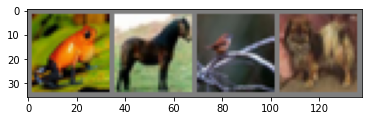

frog  horse bird  dog  


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img /2 + 0.5 # denormalize
    npimg = img.numpy()
    print(npimg.shape, np.transpose(npimg, (1,2,0)).shape) # how to rehsape
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images
(instead of 1-channel images as is was defined)

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [33]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [34]:
for epoch in range(10): # loop over dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished training')

[1,  2000] loss: 2.201
[1,  4000] loss: 1.858
[1,  6000] loss: 1.672
[1,  8000] loss: 1.573
[1, 10000] loss: 1.526
[1, 12000] loss: 1.470
[2,  2000] loss: 1.387
[2,  4000] loss: 1.375
[2,  6000] loss: 1.315
[2,  8000] loss: 1.303
[2, 10000] loss: 1.280
[2, 12000] loss: 1.238
[3,  2000] loss: 1.209
[3,  4000] loss: 1.175
[3,  6000] loss: 1.196
[3,  8000] loss: 1.171
[3, 10000] loss: 1.170
[3, 12000] loss: 1.140
[4,  2000] loss: 1.076
[4,  4000] loss: 1.098
[4,  6000] loss: 1.086
[4,  8000] loss: 1.104
[4, 10000] loss: 1.103
[4, 12000] loss: 1.075
[5,  2000] loss: 0.997
[5,  4000] loss: 1.035
[5,  6000] loss: 1.006
[5,  8000] loss: 1.044
[5, 10000] loss: 1.025
[5, 12000] loss: 1.032
[6,  2000] loss: 0.942
[6,  4000] loss: 0.955
[6,  6000] loss: 0.982
[6,  8000] loss: 0.971
[6, 10000] loss: 0.982
[6, 12000] loss: 0.975
[7,  2000] loss: 0.891
[7,  4000] loss: 0.917
[7,  6000] loss: 0.909
[7,  8000] loss: 0.923
[7, 10000] loss: 0.957
[7, 12000] loss: 0.937
[8,  2000] loss: 0.864
[8,  4000] 

Let's quickly save our trained model:

In [35]:
path = './cifar_net.pth'
torch.save(net.state_dict(), path)

### 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anyting at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

(3, 36, 138) (36, 138, 3)


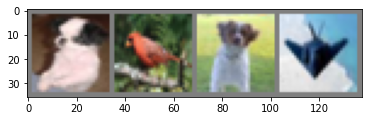

ground truth: dog   bird  dog   plane


In [36]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('ground truth:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Okay, now let us see what the neural networks thinks these examples above are:

In [37]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network
thinks that the image is of particular class. So let's get the index of the highest energy:

In [38]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   bird  bird  plane


Let's look how the network performs on the whole dataset.

In [40]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our output
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 73 %


This look better than chance which is 10% (randomly picking a class out off 10).

Let's see what are the classes that performed well.

In [41]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.7 %
Accuracy for class: car   is 92.9 %
Accuracy for class: bird  is 64.0 %
Accuracy for class: cat   is 48.9 %
Accuracy for class: deer  is 66.0 %
Accuracy for class: dog   is 64.0 %
Accuracy for class: frog  is 79.0 %
Accuracy for class: horse is 84.0 %
Accuracy for class: ship  is 87.5 %
Accuracy for class: truck is 69.3 %
